# Machine Learning Portfolio 2

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modeling](#modeling)

- [Results](#results)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [1]:
# Libraries

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


## Data Overview

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date_hour'])
test = pd.read_csv('test.csv', parse_dates=['date_hour'], index_col='date_hour')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# Train and Test data
display(train.head(10), test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,1
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,3
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,8


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343


In [8]:
# Sample submission for kaggle
display(sample_submission.head(10))

,date_hour,cnt
0,2012-12-01 00:00:00,784
1,2012-12-01 01:00:00,80
2,2012-12-01 02:00:00,605
3,2012-12-01 03:00:00,604
4,2012-12-01 04:00:00,544
5,2012-12-01 05:00:00,100
6,2012-12-01 06:00:00,344
7,2012-12-01 07:00:00,18
8,2012-12-01 08:00:00,57
9,2012-12-01 09:00:00,603


## Exploratory Data Analysis

### Train Data

In [ ]:
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


### Test Data

In [ ]:
display(test.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


### Data Types
Er zijn verschillende data types aanwezig:
- **Object**: date_hour
- **Integer**: holiday, weathersit en cnt
- **Float**: temp, atemp, hum en windspeed

In [ ]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### Controle op Ontbrekende Waarden

In [ ]:
print(train.isnull().sum())

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

### Vorm van de gegevens:

In [ ]:
print(train.shape)

(16637, 8)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

### Kolommen beschrijven:  
- **date_hour**: Datum en tijdstip.
- **holiday**: Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit**: De beschrijving van de weersomstandigheden op een schaal van 1 tot 4.
- **temp**: De normale temperatuur
- **atemp**:
- **hum**: Luchtvochtigheid
- **windspeed**: Windsnelheid
- **cnt**:

### Het meetniveau voor elke kolom:  
- **date_hour**: Interval
- **holiday**: Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit**: Ordinaal (categorieën hebben een volgorde).
- **temp**: Interval (continue variabele).
- **atemp**: Interval (continue variabele).
- **hum**: Interval (continue variabele).
- **windspeed**: Interval (continue variabele).
- **cnt**: Ratio

In [ ]:
# Converteer de kolom 'date_hour' naar datetime voor tijdreeksanalyse
train["date_hour"] = pd.to_datetime(train["date_hour"])

In [ ]:
sns.set_style('darkgrid')

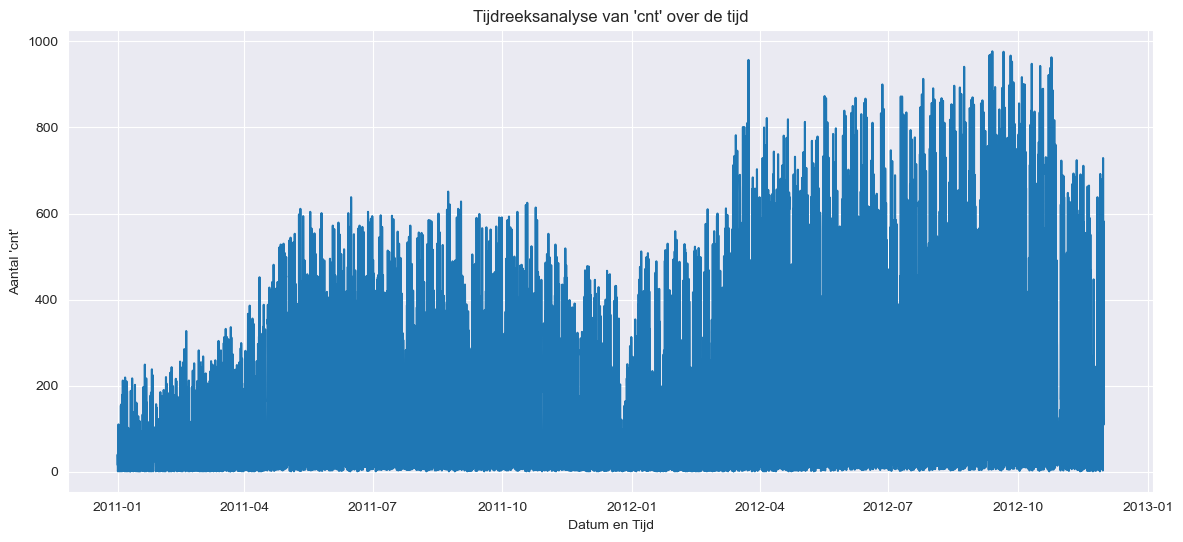

In [ ]:
# Tijdreeksanalyse van 'cnt' over de tijd
plt.figure(figsize=(14, 6))
plt.plot(train["date_hour"], train["cnt"])
plt.title("Tijdreeksanalyse van 'cnt' over de tijd")
plt.xlabel("Datum en Tijd")
plt.ylabel("Aantal 'cnt'")
plt.show()

### Verdeling van de kolommen

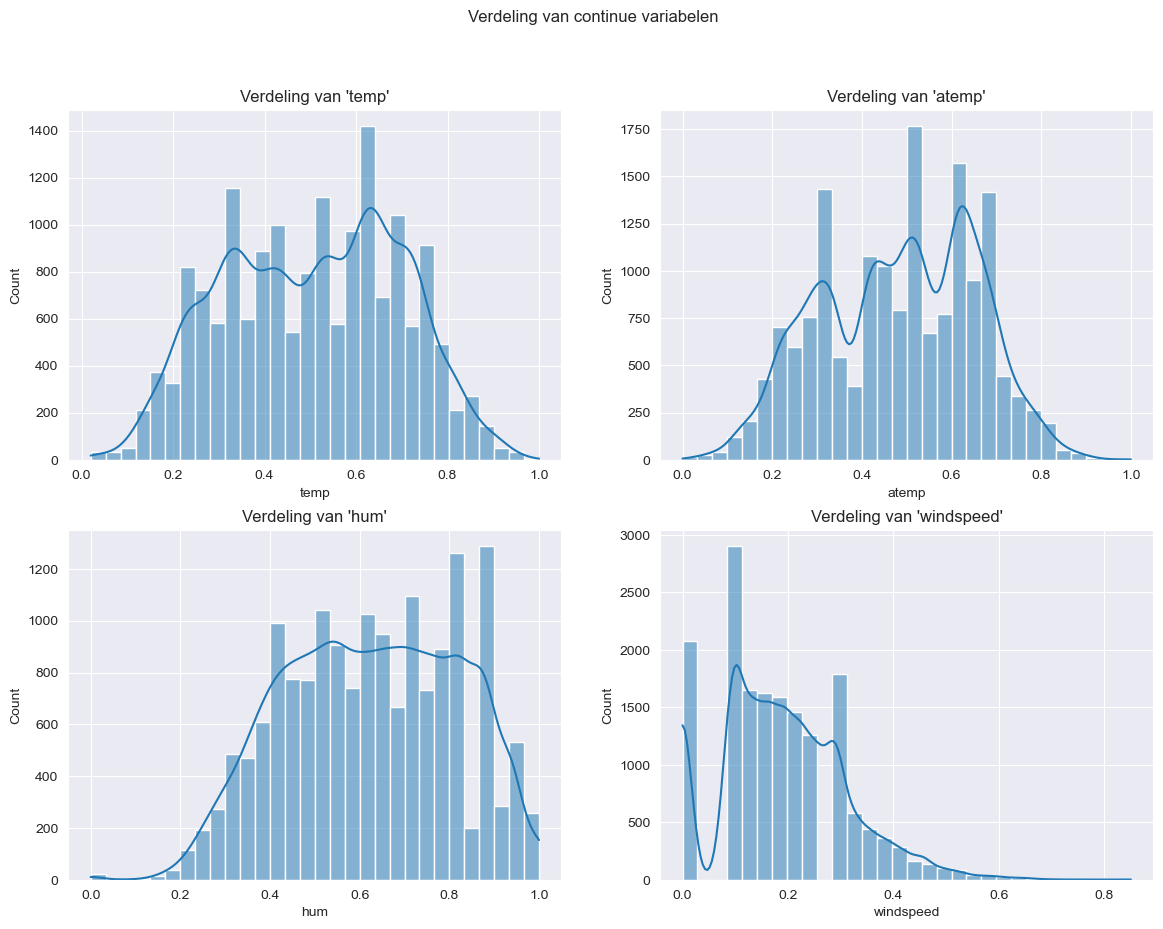

In [ ]:
# Verdelingsplots van de continue variabelen
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Verdeling van continue variabelen")

sns.histplot(train["temp"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verdeling van 'temp'")

sns.histplot(train["atemp"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Verdeling van 'atemp'")

sns.histplot(train["hum"], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verdeling van 'hum'")

sns.histplot(train["windspeed"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Verdeling van 'windspeed'")

plt.show()

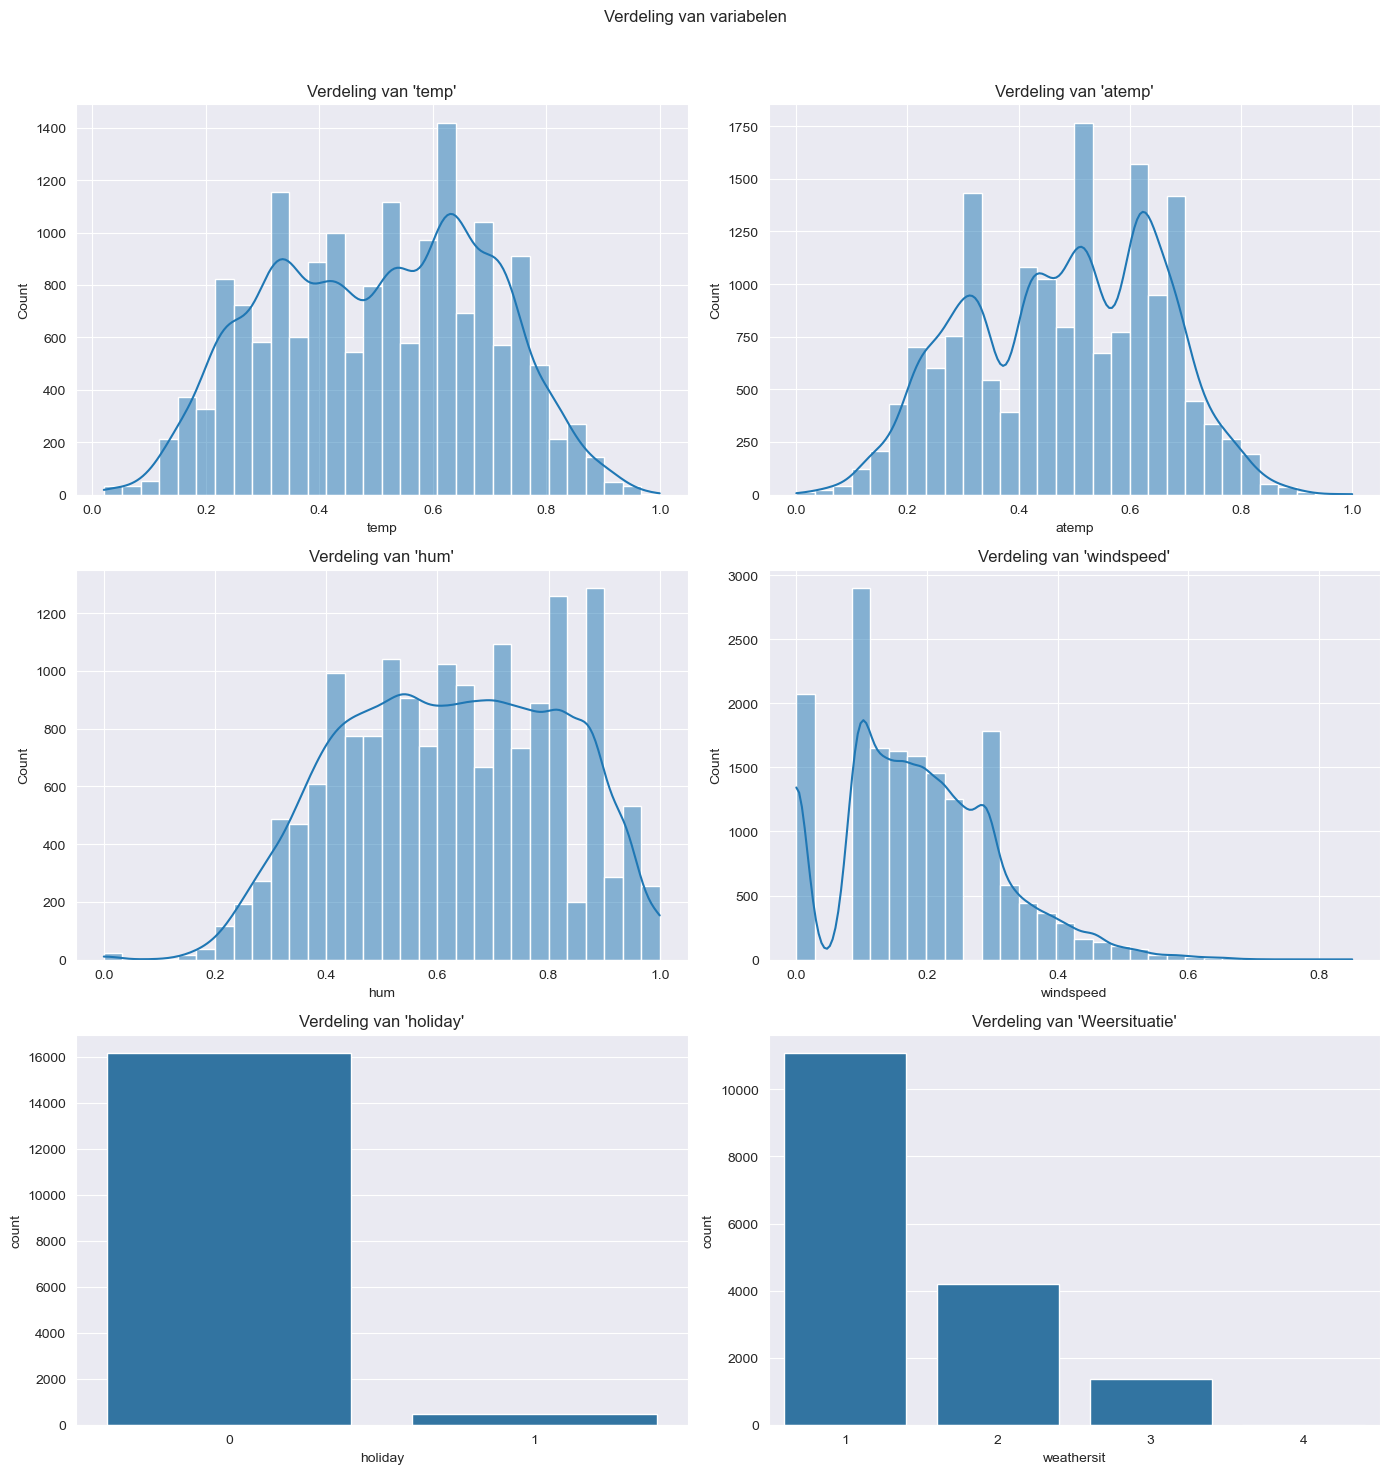

In [ ]:
# Verdelingsplots van de continue variabelen
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("Verdeling van variabelen")

# Continue variabelen
sns.histplot(train["temp"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verdeling van 'temp'")

sns.histplot(train["atemp"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Verdeling van 'atemp'")

sns.histplot(train["hum"], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verdeling van 'hum'")

sns.histplot(train["windspeed"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Verdeling van 'windspeed'")

# Categorische variabelen
sns.countplot(x=train["holiday"], ax=axes[2, 0])
axes[2, 0].set_title("Verdeling van 'holiday'")

sns.countplot(x=train["weathersit"], ax=axes[2, 1])
axes[2, 1].set_title("Verdeling van 'Weersituatie'")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Relaties

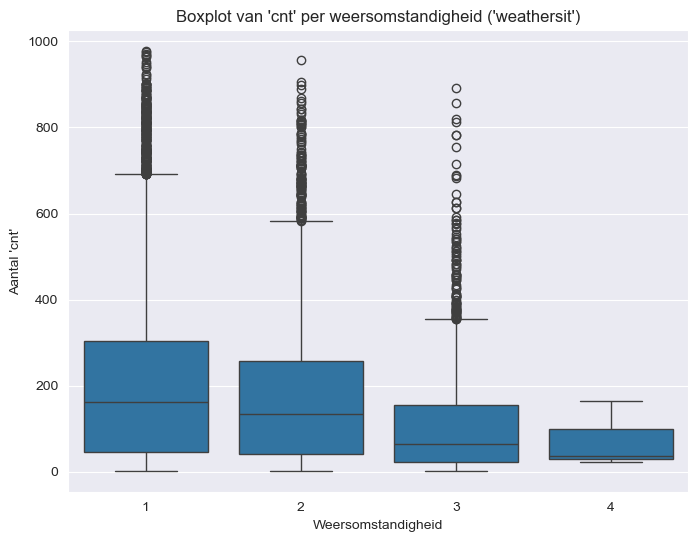

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="weathersit", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per weersomstandigheid ('weathersit')")
plt.xlabel("Weersomstandigheid")
plt.ylabel("Aantal 'cnt'")
plt.show()

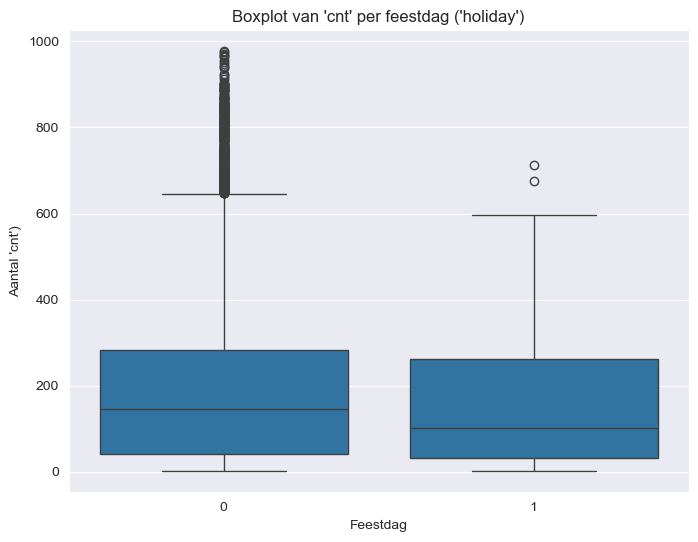

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="holiday", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per feestdag ('holiday')")
plt.xlabel("Feestdag")
plt.ylabel("Aantal 'cnt')")
plt.show()

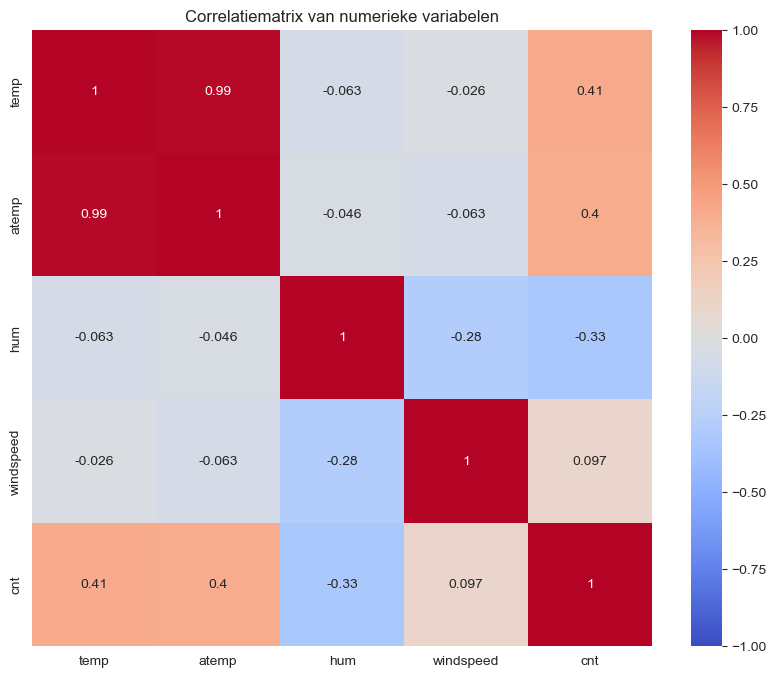

In [ ]:
# Correlatiematrix van numerieke variabelen
plt.figure(figsize=(10, 8))
correlation_matrix = train[["temp", "atemp", "hum", "windspeed", "cnt"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlatiematrix van numerieke variabelen")
plt.show()

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.
- Er blijkt heel weinig holidays te zijn
- De verdeling bij weeromstaandigheid is er te zien dat de aantallen per waarde daalt, waarbij 1 de hoogste is. 

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.

**Feature Selection:**  
Aan de hand van de visualisaties zijn de volgende features gekozen:
- weathersit (weersomstandigheid)
- temp 

#### Controle op Uitschieters

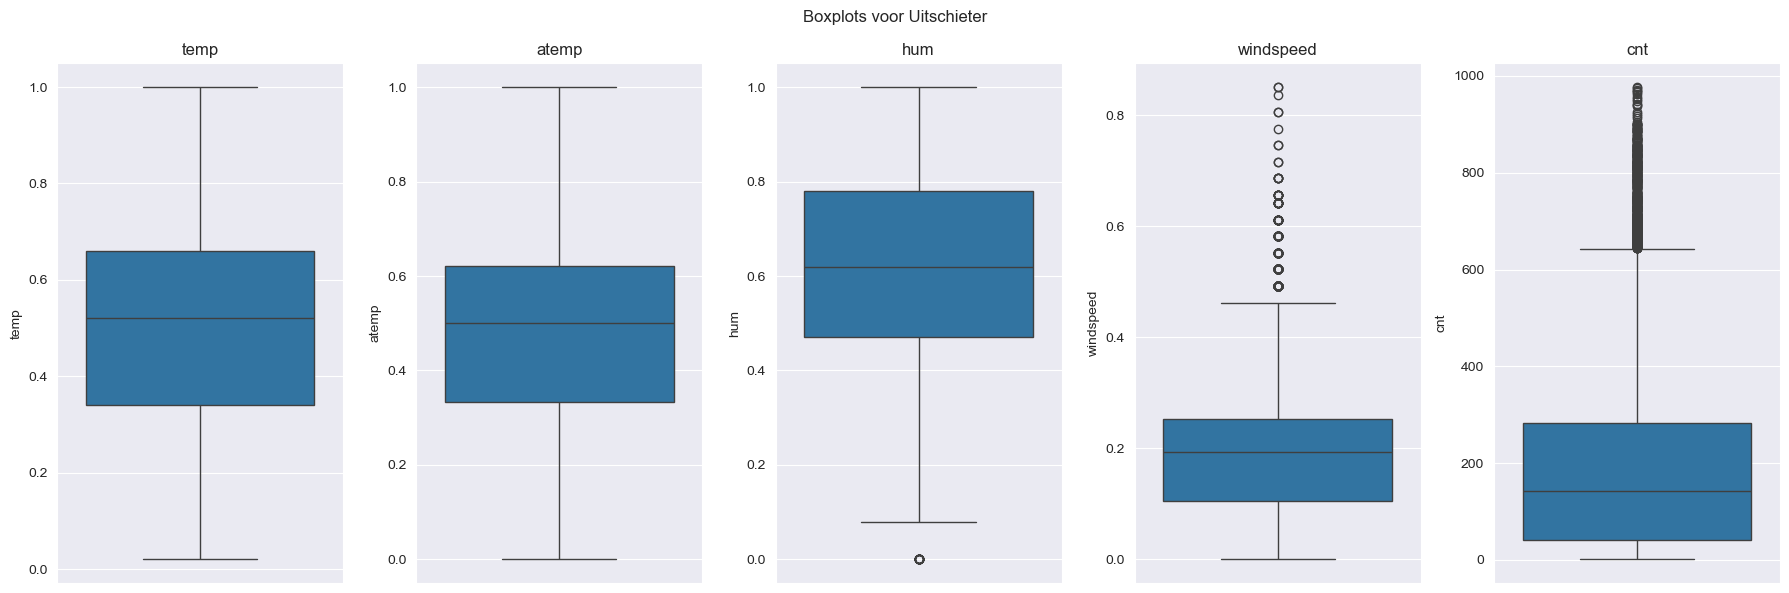

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
fig.suptitle("Boxplots voor Uitschieter")

cols_names = ["temp", "atemp", "hum", "windspeed", "cnt"]
for i, col in enumerate(cols_names):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.

In [ ]:
# Nieuwe kolommen toevoegen voor de tijdreeksanalyse van 'cnt'
train["year"] = train["date_hour"].dt.year
train["month"] = train["date_hour"].dt.month
train["day"] = train["date_hour"].dt.day
train["hour"] = train["date_hour"].dt.hour
train["weekday"] = train["date_hour"].dt.weekday
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour,weekday
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,1,0,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,1,2,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,1,3,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,1,4,5


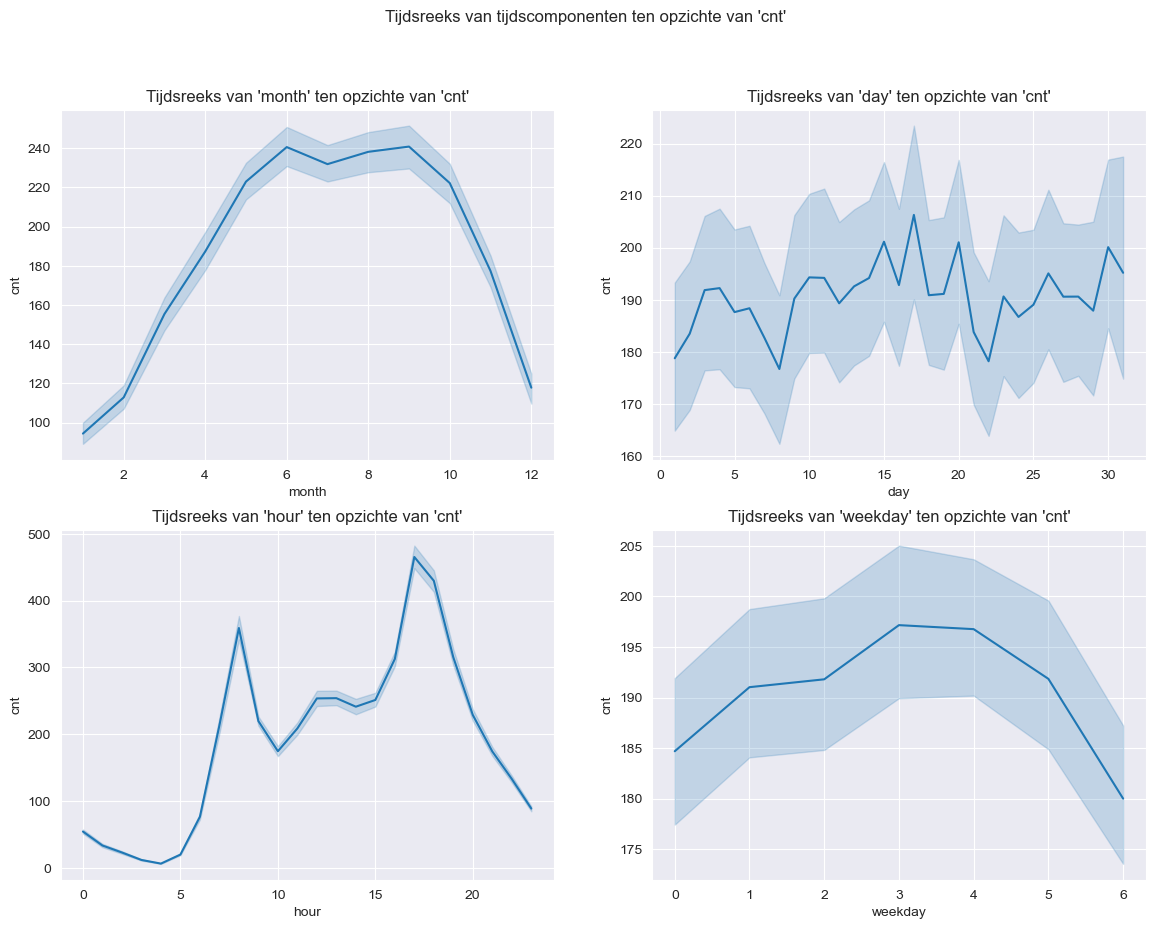

In [ ]:
# Tijdsreeksplots van de nieuwe kolommen ten opzichte van 'cnt'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Tijdsreeks van tijdscomponenten ten opzichte van 'cnt'")

# Tijdscomponenten ten opzichte van 'cnt'
sns.lineplot(x='month', y='cnt', data=train, ax=axes[0, 0])
axes[0, 0].set_title("Tijdsreeks van 'month' ten opzichte van 'cnt'")

sns.lineplot(x='day', y='cnt', data=train, ax=axes[0, 1])
axes[0, 1].set_title("Tijdsreeks van 'day' ten opzichte van 'cnt'")

sns.lineplot(x='hour', y='cnt', data=train, ax=axes[1, 0])
axes[1, 0].set_title("Tijdsreeks van 'hour' ten opzichte van 'cnt'")

sns.lineplot(x='weekday', y='cnt', data=train, ax=axes[1, 1])
axes[1, 1].set_title("Tijdsreeks van 'weekday' ten opzichte van 'cnt'")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Feature Engineering

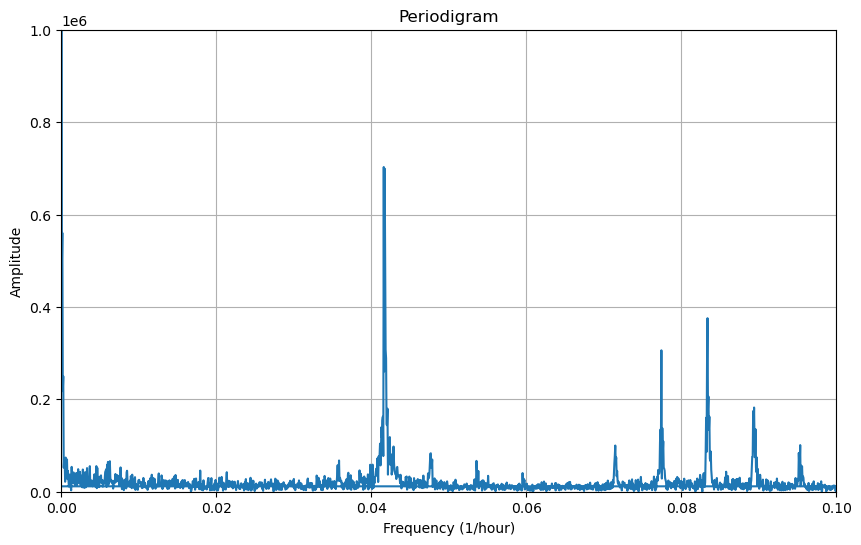

In [ ]:
tijdreeks = train['cnt']
n = len(tijdreeks)
freq = np.fft.fftfreq(n,1)
fft_result = fft(tijdreeks)

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.xlim([0,0.1])
plt.ylim([0,1e6])
plt.title('Periodigram')
plt.grid(True)
plt.show()

In [ ]:
df_fft = pd.DataFrame(np.abs(fft_result))
df_fft['freq'] = freq
hours = []
days= []
for f in freq:
    if f != 0:
        hours.append(1/f)
        days.append(1/f/24)
    else:
        hours.append(np.inf)
        days.append(np.inf)
df_fft['duur in uren'] = hours
df_fft['duur in dagen'] = days
df_fft.rename(columns={0:'amplitude'}, inplace=True)
df_fft = df_fft[(df_fft['amplitude'] > 0.4e+06)&(df_fft['freq'] > 0)]
df_fft

# daily, yearly

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422


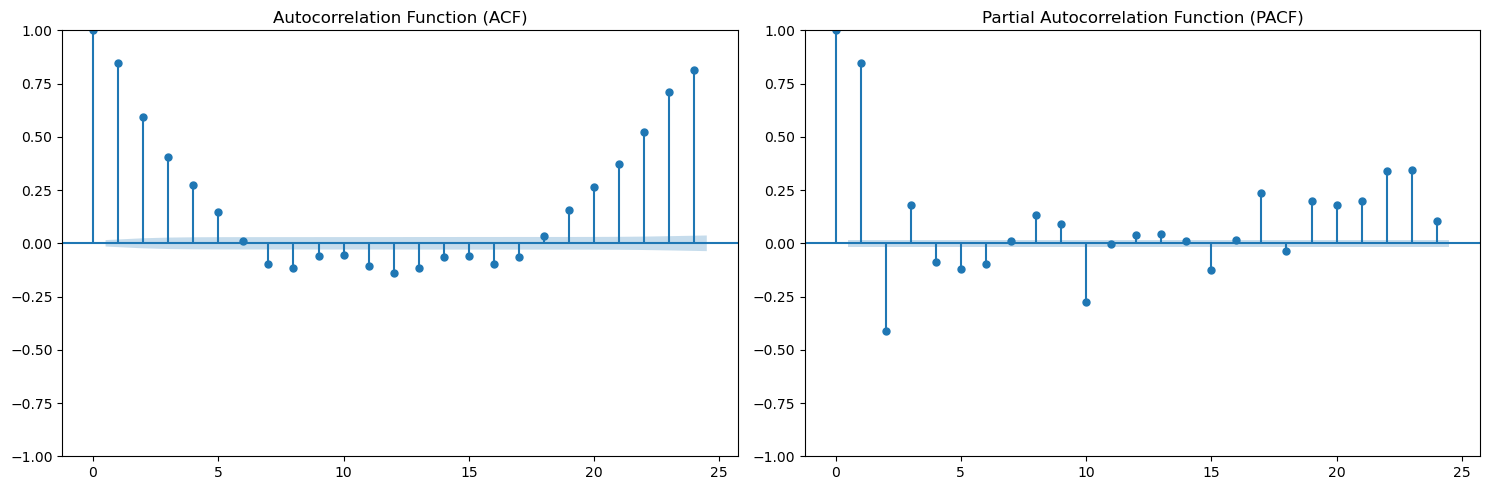

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(train['cnt'], ax=axes[0], lags=24)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(train['cnt'], ax=axes[1], lags=24)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

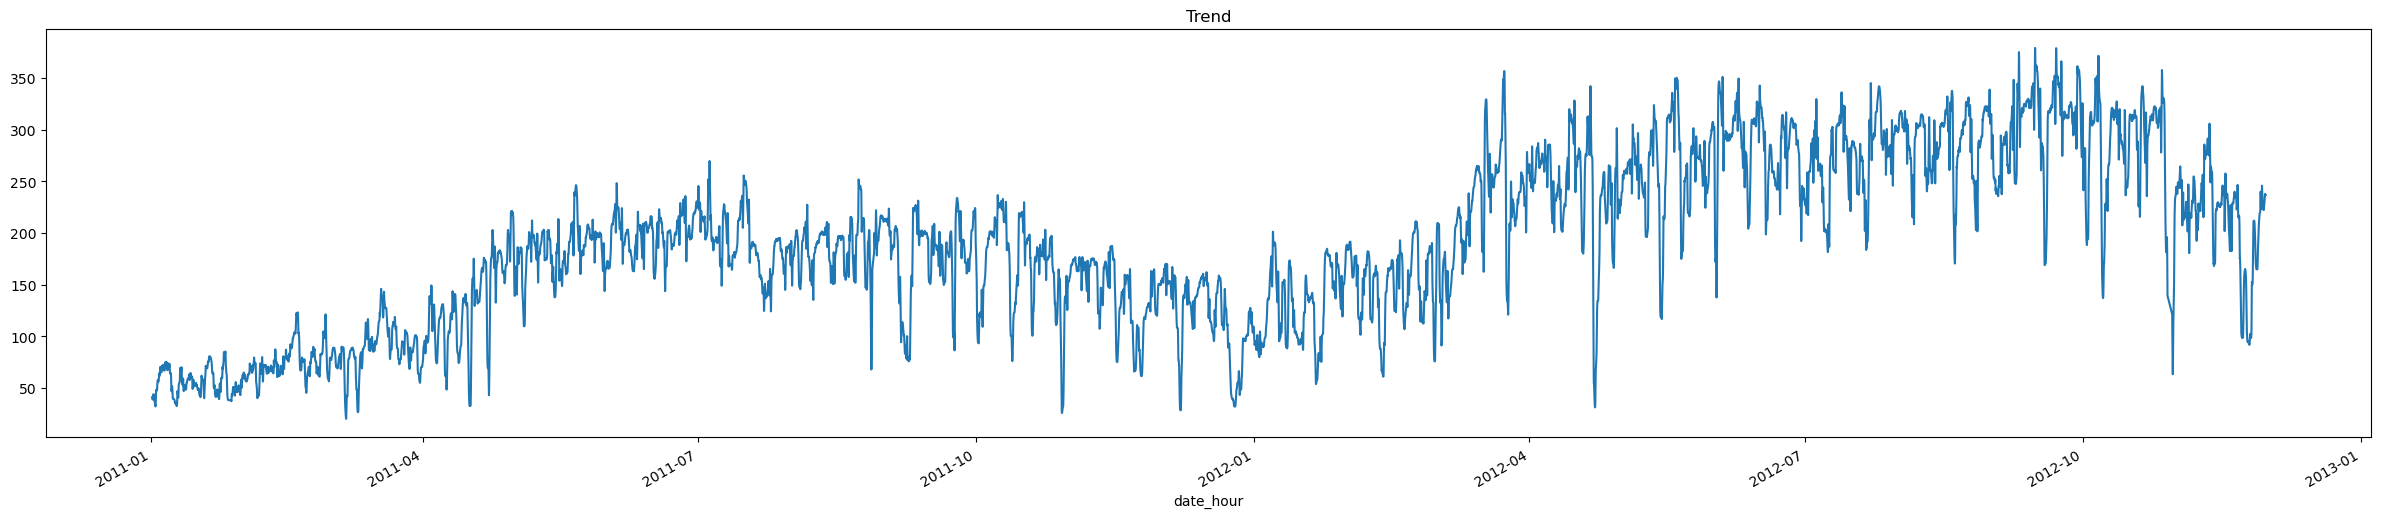

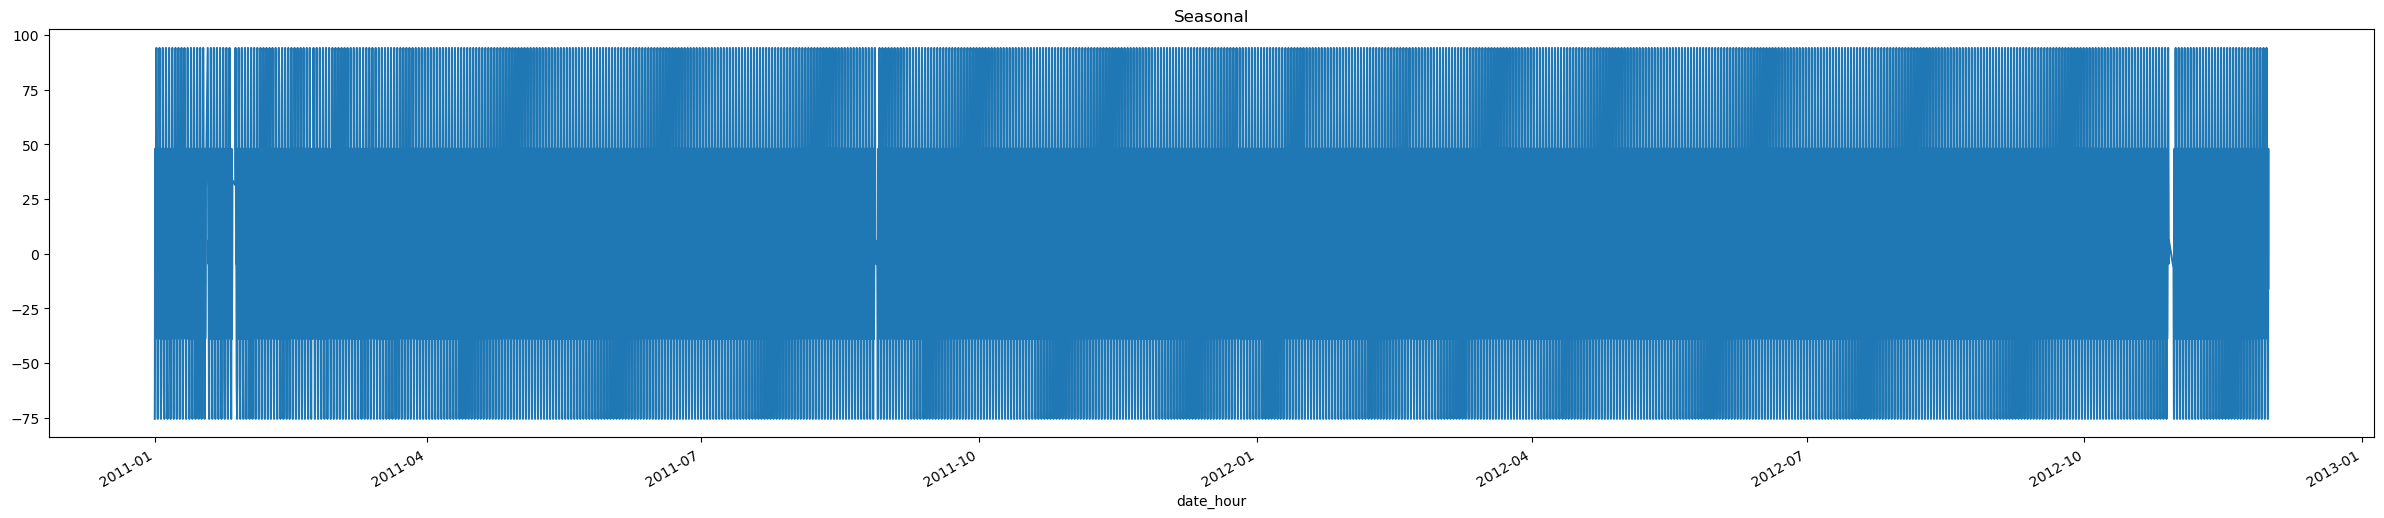

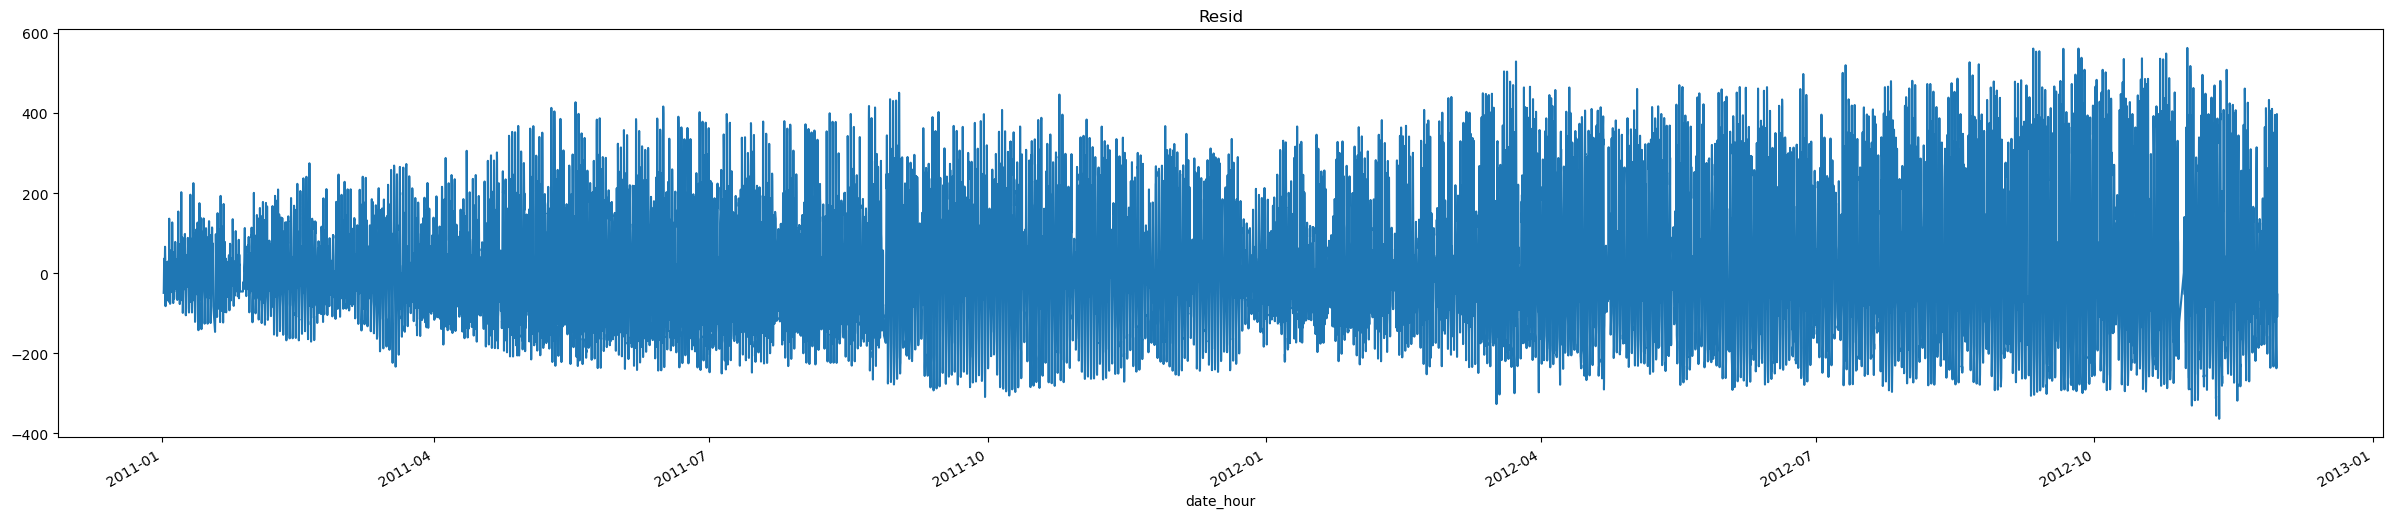

In [ ]:
sd = seasonal_decompose(train['cnt'], model='additive', period=24)
plt.figure(figsize=(30,6))
plt.title("Trend")
sd.trend.plot()
plt.figure(figsize=(30,6))
plt.title("Seasonal")
sd.seasonal.plot()
plt.figure(figsize=(30,6))
plt.title("Resid")
sd.resid.plot()
plt.show()

In [ ]:
n = 24
train[f'lag_{n}'] = train['cnt'].shift(n)
train.dropna(inplace=True)
display(train.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,lag_24
date_hour,,,,,,,,
2011-01-02 00:00:00,0,2,0.46,0.4545,0.88,0.2985,17,16.0
2011-01-02 01:00:00,0,2,0.44,0.4394,0.94,0.2537,17,40.0
2011-01-02 02:00:00,0,2,0.42,0.4242,1.00,0.2836,9,32.0
2011-01-02 03:00:00,0,2,0.46,0.4545,0.94,0.1940,6,13.0
2011-01-02 04:00:00,0,2,0.46,0.4545,0.94,0.1940,3,1.0
2011-01-02 06:00:00,0,3,0.42,0.4242,0.77,0.2985,2,1.0
2011-01-02 07:00:00,0,2,0.40,0.4091,0.76,0.1940,1,2.0
2011-01-02 08:00:00,0,3,0.40,0.4091,0.71,0.2239,8,3.0
2011-01-02 09:00:00,0,2,0.38,0.3939,0.76,0.2239,20,8.0


In [ ]:
X_train = train.drop('cnt', axis=1)
y = train['cnt']


# Create fourier
# We saw that there is a Yearly and Daily pattern.
# There are other peaks very close to the Daily frequency, we'll test with different orders.
fourier = CalendarFourier(freq='YE', order = 1) # YE-Yearly
fourier2 = CalendarFourier(freq='D', order = 1) # D-Daily

dp = DeterministicProcess(index=X_train.index, constant=False, order=1, seasonal=False,
                          additional_terms = [fourier, fourier2], drop = True)
X_train2 = dp.in_sample()
test2 = dp.out_of_sample(steps = len(test),forecast_index=test.index)

X_train = pd.concat([X_train, X_train2], axis=1)
X_test = pd.concat([test, test2], axis=1)
display(X_train.head(), X_test.head())

,holiday,weathersit,temp,atemp,hum,windspeed,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,1.0,0.000000,1.000000,0.000000,1.000000
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,2.0,0.000717,1.000000,0.258819,0.965926
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,3.0,0.001435,0.999999,0.500000,0.866025
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,4.0,0.002152,0.999998,0.707107,0.707107
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,5.0,0.002869,0.999996,0.866025,0.500000


,holiday,weathersit,temp,atemp,hum,windspeed,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,16638.0,-0.507415,0.861702,0.000000,1.000000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,16639.0,-0.506799,0.862064,0.258819,0.965926
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,16640.0,-0.506182,0.862427,0.500000,0.866025
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,16641.0,-0.505565,0.862789,0.707107,0.707107
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,16642.0,-0.504948,0.863150,0.866025,0.500000


## Modeling

## Results

## Conclusion & Advice

## Sources